# Kymograph VAE

In [68]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import json as json
import time 
from torch.optim import Adam

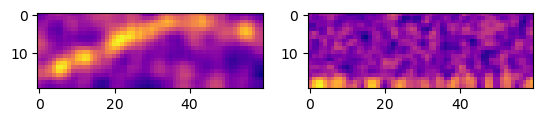

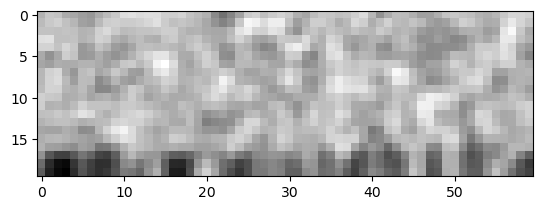

In [87]:
"""
Import artificial kymographs
"""

datapath = r'C:\Users\Aidan\Documents\Winter_2023\BE177B\Code\wonglab-capstone\ArtificialData\kymoset.json'
with open(datapath, 'r') as j:
     kymoset = json.loads(j.read())
kymoset = np.asarray(kymoset['kymoset'])

#check if imported correctly
# decoded_kymo = np.asarray(json.loads(kymoset_JSON)["kymoset"])
# I had to change the way arrays are saved in artificial generation to avoid 4-D looping problems in model training
plt.subplot(1,2,1)
plt.imshow(kymoset[0,:,:], cmap='plasma', interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(kymoset[1,:,:], cmap='plasma', interpolation='nearest')
plt.show()

#transform into data loadable by pytorch

# mnist_transform = transforms.Compose([
#         transforms.ToTensor(),
# ]) 

batch_size = 3
train_loader = DataLoader(kymoset, shuffle= True, batch_size=batch_size)

#check if loaded into pytorch correctly...
for a,b in enumerate(train_loader):
     if a == 0:
          plt.imshow(b[2,:,:], cmap='gist_gray_r')

# this is giving 50 bs (a=0...49) where each b is a tensor with dimensions [1,20,60]


#maybe display one kymograph from each subgroup to double check initial categorization

In [88]:
"""
Import experimental kymographs 
"""

#also maybe display an example to make sure it looks rights

'\nImport experimental kymographs \n'

In [89]:
""" 
Define VAE model
Imported from Jackson Kang's notebook

TO DO:
- obtain dimensions of all our layers
    x_dim: flattened dimensionality of our input space 
    hidden_dim: dimensionality of our encoder NN
    latent_dim: dimensionality of encoded space 
- decide batch size 
- decide epoch size --> smaller probably better for runtime purposes while we are figuring stuff out

"""


### Model Hyperparameters ###
batch_size = batch_size # how many images we feed each epoch (had to define above for loader)
x_dim  = 1200       # (flattened) dimensionality of our input space. 60x20 = 1200
hidden_dim = 200  # dimensionality of our encoder NN
latent_dim = 4   # dimensionality of encoded space

lr = 1e-3 #tolerance for linear regression
epochs = 10 #number of training rounds
DEVICE = torch.device("cpu") #if we get nvidia graphics card we can change this to cuda


### Encoder ###
class Encoder(nn.Module): # we must define our encoder as a subclass of the provided PyTorch neural network
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       # (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var


### Decoder ###
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


### VAE model ###
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var


### Instantiate model ###
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)


### Optimizer ###
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

In [90]:
"""" 
Train VAE model
"""

print("---Super sus VAE Training---")
model.train()

for epoch in range(epochs):

    startTime = time.perf_counter()
    overall_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    timediff = (time.perf_counter()-startTime)
    print("\tEpoch {} complete \tAverage Loss: {} \tTraining time: {} ".format(epoch+1, overall_loss / (batch_idx*batch_size), timediff))
    
print("Finish!!")

---Super sus VAE Training---


RuntimeError: mat1 and mat2 must have the same dtype